# Implementation that works with hugginface models and datasets for greater reproducibility

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from datasets import load_dataset
from torch import nn
from torch.nn import functional as F
from tqdm.autonotebook import tqdm
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image

from src.adversarial_noise.utils import get_device
from src.adversarial_noise.fgsm import (
    iterative_fast_gradient_sign_target,
    tensor_to_image,
)
from src.adversarial_noise.evaluation import plot_adversarial_results
from src.adversarial_noise.evaluation import evaluate_adversarial_attacks


In [2]:
device = get_device()

Start using the same model and dataset as the existing example (resnet34 and tiny imagenet)

In [3]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Define a test image

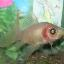

In [4]:
image = dataset["train"]["image"][0]
image


In [5]:
inputs = image_processor(image, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

goldfish, Carassius auratus


In [6]:
label_names = list(model.config.id2label.values())
label_names

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [7]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="eft",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.002,
    num_iter=10,
)

In [8]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
eft                             98.72%
common newt, Triturus vulgaris   0.61%
goldfish, Carassius auratus      0.14%
axolotl, mud puppy, Ambystoma mexicanum   0.06%
spotted salamander, Ambystoma maculatum   0.05%
mongoose                         0.02%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui   0.01%
ringlet, ringlet butterfly       0.01%
European fire salamander, Salamandra salamandra   0.01%
Windsor tie                      0.01%


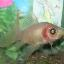

In [9]:
image

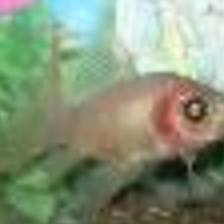

In [10]:
tensor_to_image(adv_imgs)

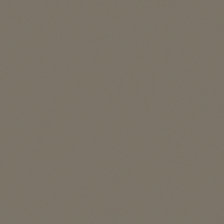

In [11]:
tensor_to_image(noise_grad)

In [12]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich, Struthio camelus",
    label_names=label_names,
    alpha=0.002,
    num_iter=10,
)

In [13]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
ostrich, Struthio camelus       95.32%
patas, hussar monkey, Erythrocebus patas   0.78%
macaque                          0.68%
crane                            0.51%
baboon                           0.31%
hen                              0.24%
black stork, Ciconia nigra       0.17%
vulture                          0.09%
marmoset                         0.09%
hornbill                         0.08%


In [14]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)

## Test with a different dataset 

In [15]:
dataset = load_dataset("huggingface/cats-image", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [16]:
image = dataset["test"]["image"][0]
inputs = image_processor(image, return_tensors="pt")

In [17]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich, Struthio camelus",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.02,
    num_iter=10,
)

In [18]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)

Still works, but requires higher alpha

# More thorough testing

In [19]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
seed = np.random.seed(42)  # Set a seed for reproducibility

In [20]:
model = model.to(device)
results = evaluate_adversarial_attacks(
    model=model,
    dataset=dataset,
    image_processor=image_processor,
    n_samples=10,
    alpha=0.02,
    num_iter=10,
    device=device,
    seed=seed,
)

Running adversarial attacks:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Test fuzzy matching

In [21]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.02,
    num_iter=10,
)

Found substring match: 'ostrich' → 'ostrich, Struthio camelus'


# Test conversion to image then reclassification

In [22]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")
image = dataset["train"]["image"][0]
inputs = image_processor(image, return_tensors="pt")

In [23]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.02,
    num_iter=10,
)

Found substring match: 'ostrich' → 'ostrich, Struthio camelus'


In [24]:
re_inputs = image_processor(tensor_to_image(adv_imgs), return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**re_inputs).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

ostrich, Struthio camelus


In [25]:
adv_imgs

tensor([[[[ 2.1804e+00,  2.1004e+00,  2.1004e+00,  ...,  1.6724e+00,
            1.7124e+00,  1.8038e+00],
          [ 2.0662e+00,  2.0662e+00,  2.0662e+00,  ...,  1.7638e+00,
            1.7638e+00,  1.6780e+00],
          [ 2.1119e+00,  2.0719e+00,  2.1119e+00,  ...,  1.7980e+00,
            1.6780e+00,  1.6723e+00],
          ...,
          [-4.8530e-01, -5.4243e-01, -5.5955e-01,  ..., -1.1647e+00,
           -1.0275e+00, -9.9329e-01],
          [-5.2530e-01, -5.4243e-01, -5.5955e-01,  ..., -9.5329e-01,
           -1.0162e+00, -9.8192e-01],
          [-5.0818e-01, -5.6530e-01, -5.8243e-01,  ..., -8.3342e-01,
           -7.7630e-01, -9.1917e-01]],

         [[ 4.1527e-01,  4.1028e-01,  4.8529e-01,  ...,  2.0659e+00,
            2.0834e+00,  2.1759e+00],
          [ 3.5277e-01,  4.2779e-01,  5.4280e-01,  ...,  2.1584e+00,
            2.1359e+00,  2.1085e+00],
          [ 3.9277e-01,  5.0779e-01,  5.8280e-01,  ...,  2.0734e+00,
            2.0910e+00,  2.1035e+00],
          ...,
     

In [26]:
inputs

{'pixel_values': tensor([[[[ 2.1804,  2.1804,  2.1804,  ...,  1.6324,  1.6324,  1.6838],
          [ 2.1462,  2.1462,  2.1462,  ...,  1.6838,  1.6838,  1.7180],
          [ 2.1119,  2.1119,  2.1119,  ...,  1.7180,  1.7180,  1.7523],
          ...,
          [-0.5253, -0.5424, -0.5596,  ..., -1.1247, -1.1075, -1.0733],
          [-0.5253, -0.5424, -0.5596,  ..., -1.0733, -1.0562, -1.0219],
          [-0.5082, -0.5253, -0.5424,  ..., -0.9534, -0.9363, -0.9192]],

         [[ 0.4153,  0.4503,  0.4853,  ...,  2.0259,  2.0434,  2.0959],
          [ 0.4328,  0.4678,  0.5028,  ...,  2.0784,  2.0959,  2.1485],
          [ 0.4328,  0.4678,  0.5028,  ...,  2.1134,  2.1310,  2.1835],
          ...,
          [-0.0574, -0.0574, -0.0924,  ..., -1.1604, -1.1604, -1.1253],
          [-0.0574, -0.0574, -0.0924,  ..., -1.1078, -1.1078, -1.0728],
          [-0.0399, -0.0399, -0.0749,  ..., -0.9853, -0.9853, -0.9678]],

         [[ 1.8034,  1.8208,  1.8208,  ...,  2.1346,  2.1520,  2.2217],
          [ 1

Seems like conversion to image messes with the noise. Simplify processing and image creation?

In [27]:
def tensor_to_image_simple(tensor: torch.Tensor) -> Image.Image:
    """Convert a tensor to PIL Image with minimal processing."""
    # Remove batch dimension and move to CPU
    img_array = tensor[0].cpu().numpy()

    # Transpose from (C,H,W) to (H,W,C)
    img_array = np.transpose(img_array, (1, 2, 0))

    return Image.fromarray((img_array * 255).astype(np.uint8))


def image_to_tensor(image: Image.Image) -> torch.Tensor:
    """Convert PIL Image back to tensor with minimal processing."""
    # Convert to numpy array and normalize to 0-1
    img_array = np.array(image).astype(np.float32) / 255.0

    # Transpose from (H,W,C) to (C,H,W) and add batch dimension
    img_array = np.transpose(img_array, (2, 0, 1))

    return torch.from_numpy(img_array).unsqueeze(0)


# Test the roundtrip conversion
def test_conversion(original_tensor: torch.Tensor) -> float:
    """Test roundtrip conversion and return max absolute difference."""
    image = tensor_to_image_simple(original_tensor)
    reconstructed_tensor = image_to_tensor(image)

    # Compare original and reconstructed tensors
    diff = (original_tensor - reconstructed_tensor).abs().max().item()
    print(f"Max absolute difference: {diff}")
    return diff

In [28]:
# Test with your adversarial image
diff = test_conversion(adv_imgs.to("cpu"))

Max absolute difference: 3.0130629539489746


Only step still there is the normalisation step

In [29]:
from src.adversarial_noise.fgsm import fuzzy_match_label


def iterative_fast_gradient_sign_target(
    model: ResNetForImageClassification,
    image: torch.Tensor,
    target_label: str,
    label_names: list,
    num_iter: int = 10,
    alpha: float = 0.002,
    verbose: bool = False,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Iterative Fast Gradient Sign Method (FGSM) for targeted attacks.
    Handles normalization explicitly to ensure adversarial perturbations survive image conversion.

    Args:
        model: Image classification model.
        image: Input images to attack (assumed to be normalized).
        target_label: Target label for the attack.
        label_names: List of all label names recognized by the model.
        num_iter: Number of iterations for the attack.
        alpha: Step size for noise to add to the image.
        verbose: Whether to print target and predicted labels.

    Returns:
        Tuple of adversarial images and noise gradients.
    """
    # ImageNet normalization constants
    mean = torch.tensor([0.485, 0.456, 0.406], device=image.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image.device).view(1, 3, 1, 1)

    target_label = fuzzy_match_label(target_label, label_names)
    target_label_idx = torch.tensor(model.config.label2id[target_label])
    target_label_idx = target_label_idx.to(image.device)
    target_labels = torch.full(
        (image.size(0),),
        fill_value=target_label_idx,
        dtype=torch.long,
        device=image.device,
    )

    # Denormalize the input image to 0-1 range
    denorm_image = image * std + mean
    adv_image = denorm_image.clone()

    for _ in range(num_iter):
        # Normalize the image before model input
        norm_adv_image = (adv_image - mean) / std
        norm_adv_image = norm_adv_image.detach().requires_grad_()

        outputs = model(norm_adv_image)
        logits = outputs.logits
        preds = F.log_softmax(logits, dim=-1)
        loss = -torch.nn.CrossEntropyLoss()(preds, target_labels)
        loss.sum().backward()

        if norm_adv_image.grad is None:
            raise ValueError("Gradient is None")

        # Scale the gradient back to denormalized space
        scaled_grad = norm_adv_image.grad * std
        noise_grad = torch.sign(scaled_grad)

        # Update in denormalized space
        adv_image = adv_image + alpha * noise_grad

        # Clip to valid image range
        adv_image = torch.clamp(adv_image, 0, 1)

    # Calculate noise in denormalized space
    noise_grad = adv_image - denorm_image

    # Final prediction using normalized image
    final_norm_image = (adv_image - mean) / std
    with torch.no_grad():
        final_logits = model(final_norm_image).logits
        predicted_id = final_logits.argmax(-1).item()
        predicted_label = model.config.id2label[predicted_id]

    if predicted_label != target_label:
        print(
            f"Failed to target {target_label} with {predicted_label}. Increase alpha or num_iter."
        )

    if verbose:
        print(f"Target label: {target_label}, Achieved label: {predicted_label}")

    # Return the adversarial image in normalized space to match input
    normalized_adv_image = (adv_image - mean) / std
    return normalized_adv_image.detach(), noise_grad.detach()

In [38]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich, Struthio camelus",
    label_names=label_names,
    alpha=0.002,
    num_iter=100,
)

In [39]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)

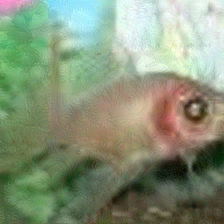

In [40]:
tensor_to_image(adv_imgs)

In [41]:
re_inputs = image_processor(tensor_to_image(adv_imgs), return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**re_inputs).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

ostrich, Struthio camelus


In [42]:
with torch.no_grad():
    logits = model(**re_inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
ostrich, Struthio camelus       99.58%
titi, titi monkey                0.07%
hamster                          0.03%
tarantula                        0.03%
baboon                           0.02%
macaque                          0.02%
hen                              0.02%
meerkat, mierkat                 0.01%
marmoset                         0.01%
capuchin, ringtail, Cebus capucinus   0.01%
